In [1]:
import pandas as pd
import numpy as np
import os

os.chdir("..")

from scripts.preprocessing import PreProcessor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
preprocessor = PreProcessor()
Xs, ys = preprocessor.run_processes(resample=False, scale=True, reduce=True)

X_test, X_train, X_val = Xs
y_test, y_train, y_val = ys

Train: 7556 | 0.22789835892006352
Val: 1890 | 0.22804232804232805
Test: 2362 | 0.2277730736663844


In [5]:
model = xgb.XGBClassifier(objective = 'binary:logistic', random_state=preprocessor.seed)

param_grid = {
    'max_depth':[2,5,10]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring='roc_auc',
    cv=3,
    )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [2, 5, 10]}, scoring='roc_auc')

In [6]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7064171789581545
{'max_depth': 2}


## Validation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
sns.set_theme()

In [8]:
best_model = xgb.XGBClassifier(
    objective = 'binary:logistic', 
    random_state=preprocessor.seed,
    max_depth = grid_search.best_params_['max_depth'],
    n_estimators = 100,
    eval_metric='auc'
    
    )
best_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)])

[0]	validation_0-auc:0.64510	validation_1-auc:0.64117


[1]	validation_0-auc:0.67499	validation_1-auc:0.66466
[2]	validation_0-auc:0.69073	validation_1-auc:0.68283
[3]	validation_0-auc:0.69776	validation_1-auc:0.69185
[4]	validation_0-auc:0.70396	validation_1-auc:0.69772
[5]	validation_0-auc:0.71076	validation_1-auc:0.70174
[6]	validation_0-auc:0.71314	validation_1-auc:0.70483
[7]	validation_0-auc:0.71665	validation_1-auc:0.70248
[8]	validation_0-auc:0.71901	validation_1-auc:0.70447
[9]	validation_0-auc:0.72088	validation_1-auc:0.70589
[10]	validation_0-auc:0.72290	validation_1-auc:0.70694
[11]	validation_0-auc:0.72460	validation_1-auc:0.70651
[12]	validation_0-auc:0.72708	validation_1-auc:0.70859
[13]	validation_0-auc:0.72835	validation_1-auc:0.70982
[14]	validation_0-auc:0.73042	validation_1-auc:0.71064
[15]	validation_0-auc:0.73250	validation_1-auc:0.70957
[16]	validation_0-auc:0.73436	validation_1-auc:0.71009
[17]	validation_0-auc:0.73479	validation_1-auc:0.71095
[18]	validation_0-auc:0.73617	validation_1-auc:0.71293
[19]	validation_0-a

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
train_auc = best_model.evals_result()['validation_0']['auc']
val_auc = best_model.evals_result()['validation_1']['auc']
iterations = range(0, len(val_auc))

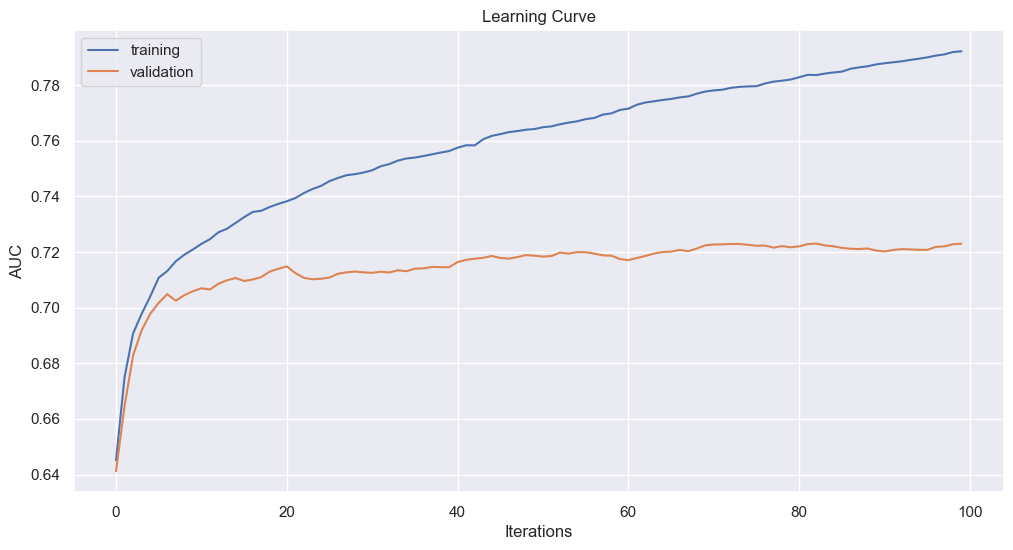

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(iterations, train_auc, label='training')
ax.plot(iterations, val_auc, label='validation')
ax.set_title('Learning Curve')
ax.set_xlabel('Iterations')
ax.set_ylabel('AUC')
ax.legend()

In [11]:
y_val_preds_proba = best_model.predict_proba(X_val)[:,1]

In [12]:
from sklearn.metrics import roc_curve

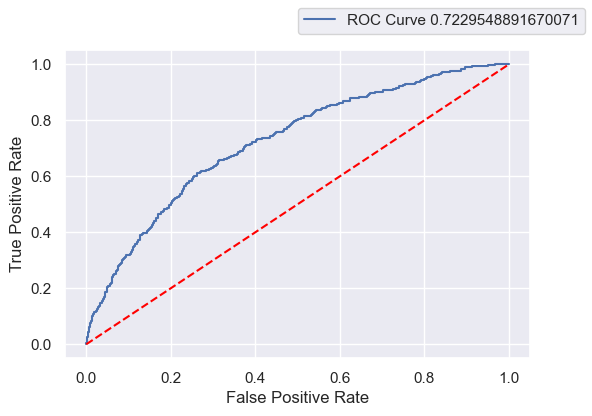

In [13]:
fpr, tpr, _ = roc_curve(y_val, y_val_preds_proba)
auc = roc_auc_score(y_val, y_val_preds_proba)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(fpr, tpr, label=f'ROC Curve {auc}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1],[0,1], color='red', linestyle='--')
fig.legend()

In [14]:
precision_val, recall_val, t_val = precision_recall_curve(y_val, y_val_preds_proba)

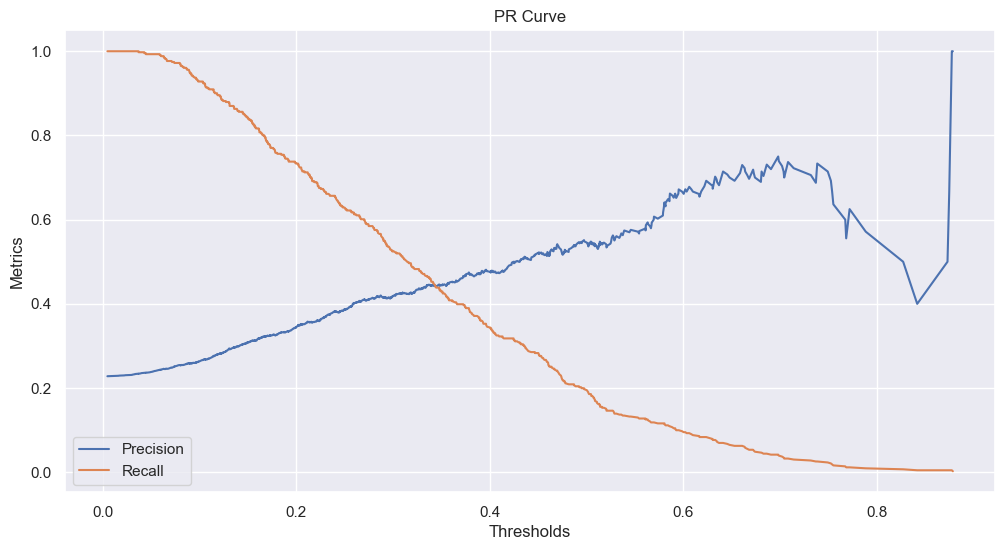

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t_val, precision_val[:-1], label='Precision')
ax.plot(t_val, recall_val[:-1], label='Recall')
ax.set_title('PR Curve')
ax.set_xlabel('Thresholds')
ax.set_ylabel('Metrics')
ax.legend()

In [16]:
optimal_t = 0.37

In [17]:
y_test_preds_proba = best_model.predict_proba(X_test)[:,1]
y_test_preds = (y_test_preds_proba>optimal_t).astype(int)

precision_test = precision_score(y_test, y_test_preds)
recall_test = recall_score(y_test, y_test_preds)

print(f"Precision {precision_test} | Recall {recall_test}")

roc_auc_score(y_test, y_test_preds)

Precision 0.45390070921985815 | Recall 0.35687732342007433


0.6151162932889845